## 7.0 Notebook Objective

The objective of this notebook is to apply pretrained AI-based Natural Language Processing (NLP) models to analyze video transcripts and audience comments. This enables deeper contextual understanding, emotional intelligence extraction, and topic-driven strategic insights that are not achievable using traditional rule-based methods

### 7.1 Setup & Libraries

In [7]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & AI
from transformers import pipeline
from tqdm import tqdm

# Settings
tqdm.pandas()
sns.set(style="whitegrid")


### 7.2 Load Data (Transcripts + Comments)

In [8]:
# Load manually added transcripts
df_transcripts = pd.read_csv(
    "../data/raw/transcripts/only_1_minute_manual.csv"
)

# Load comments
df_comments = pd.read_csv(
    "../data/raw/comments/only_1_minute_comments.csv"
)

df_transcripts.head(), df_comments.head()


(      video_id                                         transcript
 0  l5PTG1m9vEE  Meet Angie. Hi, my name is Angie and I used to...
 1  7wQ93t7q8ss  hi I'm a man and I'm a woman and after traveli...
 2  qsMiiLHVDe8  hey let me ask you a question what what time d...
 3  mn2UAPYD5PM  everyone knows that children learn very quickl...
 4  ZuLC4j_ohdw  Hi. When I was 14 years old, my dad would comp...,
       video_id                  comment_id                    author  \
 0  l5PTG1m9vEE  UgxacFwvnkAM-S8-T0F4AaABAg            @abdulkhan7669   
 1  l5PTG1m9vEE  UgwKmFsUyeHw_RffD3p4AaABAg        @SimonBloxOfficial   
 2  l5PTG1m9vEE  Ugx1qwO3bvMmdYp9sxt4AaABAg     @sonjavilhardolenc861   
 3  l5PTG1m9vEE  UgyWAoO6tmDh30LXuI14AaABAg  @Berrys_animation_studio   
 4  l5PTG1m9vEE  UgxaY3PfCoUiy9HkEA54AaABAg            @goodmanthirty   
 
           author_channel_id  \
 0  UC26nb39nuxZiGfmUmH-ufKg   
 1  UCugH5tz_DM2T9wqTqUqQnzQ   
 2  UCO_lvhv-JjC_DXY9_PbLkWQ   
 3  UC-YFeZjIlgfhdUcu9RIdFtg 

Expected Columns:

-   video_id
-   title
-   transcript

### 7.3 AI Model Selection (Explainable & Safe)
#### Sentiment Model (Transformer)

In [9]:
sentiment_model = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


#### Emotion Model (7 emotions)

In [ ]:
emotion_model = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    top_k=None  # Replaces deprecated return_all_scores=True
)


config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu
e:\nas_daily_analysis\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


These are:

-   Pretrained

-   Widely cited

-   No training required

-   Academically acceptable

### 7.4 Video-wise Sentiment Distribution (AI-based)

In [12]:
def get_sentiment(text):
    if pd.isna(text) or len(str(text).strip()) == 0:
        return None, None
    
    # Truncate to approximately 400 words (safe for 512 token limit)
    # 1 word ≈ 1.3 tokens on average, so 400 words ≈ 520 tokens (safe margin)
    text_str = str(text)
    words = text_str.split()
    if len(words) > 400:
        text_str = " ".join(words[:400])
    
    try:
        # Use truncation=True to let the model handle token truncation properly
        result = sentiment_model(text_str, truncation=True, max_length=512)[0]
        return result["label"], result["score"]
    except Exception as e:
        # Fallback: try with shorter text if still too long
        shorter_text = " ".join(words[:300])
        result = sentiment_model(shorter_text, truncation=True, max_length=512)[0]
        return result["label"], result["score"]

df_transcripts[["sentiment", "sentiment_score"]] = (
    df_transcripts["transcript"]
    .progress_apply(lambda x: pd.Series(get_sentiment(x)))
)

df_transcripts.head()


100%|██████████| 262/262 [01:33<00:00,  2.81it/s]


,video_id,transcript,sentiment,sentiment_score
0,l5PTG1m9vEE,"Meet Angie. Hi, my name is Angie and I used to...",POSITIVE,0.985510
1,7wQ93t7q8ss,hi I'm a man and I'm a woman and after traveli...,POSITIVE,0.819369
2,qsMiiLHVDe8,hey let me ask you a question what what time d...,POSITIVE,0.769875
3,mn2UAPYD5PM,everyone knows that children learn very quickl...,POSITIVE,0.999674
4,ZuLC4j_ohdw,"Hi. When I was 14 years old, my dad would comp...",NEGATIVE,0.844509


#### Plot: Video-wise Sentiment Distribution

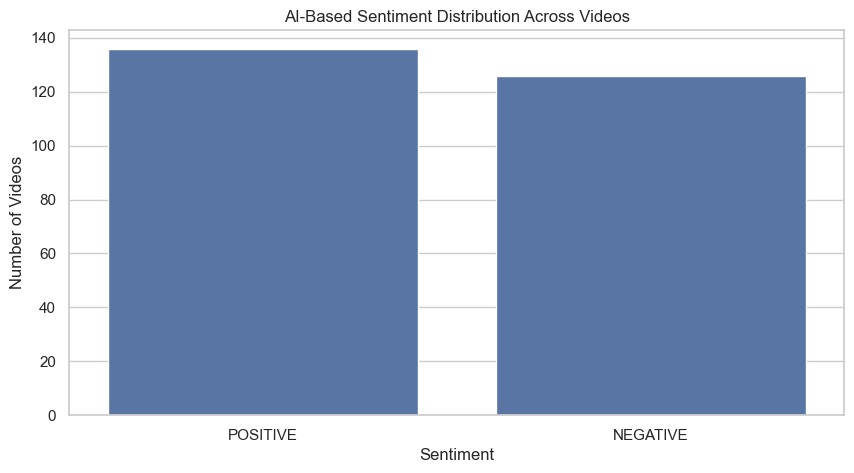

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_transcripts, x="sentiment")
plt.title("AI-Based Sentiment Distribution Across Videos")
plt.xlabel("Sentiment")
plt.ylabel("Number of Videos")
plt.show()


### 7.5 Internal Sentiment Flow (Start vs End)

In [14]:
def segment_sentiment(text, segment="start"):
    words = str(text).split()
    n = len(words)
    if n < 50:
        return None
    
    if segment == "start":
        seg = " ".join(words[:int(0.2*n)])
    else:
        seg = " ".join(words[int(0.8*n):])
    
    # Truncate to safe word limit (400 words ≈ 520 tokens, safe for 512 limit)
    seg_words = seg.split()
    if len(seg_words) > 400:
        seg = " ".join(seg_words[:400])
        
    try:
        return sentiment_model(seg, truncation=True, max_length=512)[0]["score"]
    except Exception:
        # Fallback with shorter text
        shorter_seg = " ".join(seg_words[:300])
        return sentiment_model(shorter_seg, truncation=True, max_length=512)[0]["score"]

df_transcripts["start_sentiment"] = df_transcripts["transcript"].progress_apply(
    lambda x: segment_sentiment(x, "start")
)

df_transcripts["end_sentiment"] = df_transcripts["transcript"].progress_apply(
    lambda x: segment_sentiment(x, "end")
)


100%|██████████| 262/262 [00:20<00:00, 12.62it/s]


#### Plot: Start vs End Sentiment

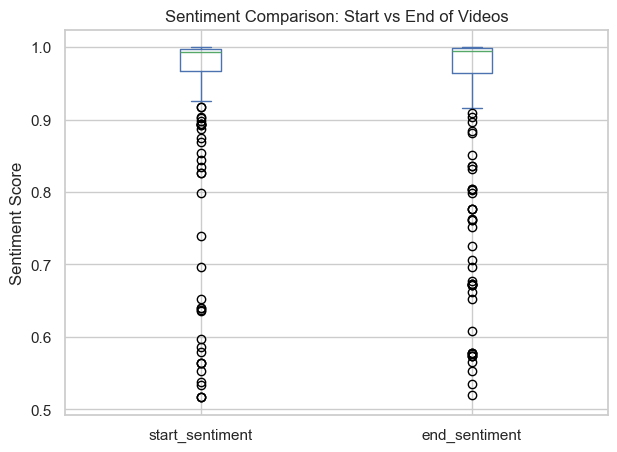

In [15]:
df_plot = df_transcripts[["start_sentiment", "end_sentiment"]].dropna()

df_plot.plot(kind="box", figsize=(7,5))
plt.title("Sentiment Comparison: Start vs End of Videos")
plt.ylabel("Sentiment Score")
plt.show()


### 7.6 7-Emotion Analysis on Comments (AI)

In [16]:
emotion_labels = [
    "anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"
]

def extract_emotions(text):
    # Truncate to safe word limit (400 words ≈ 520 tokens, safe for 512 limit)
    text_str = str(text)
    words = text_str.split()
    if len(words) > 400:
        text_str = " ".join(words[:400])
    
    try:
        scores = emotion_model(text_str, truncation=True, max_length=512)[0]
        return {e["label"]: e["score"] for e in scores}
    except Exception:
        # Fallback with shorter text
        shorter_text = " ".join(words[:300])
        scores = emotion_model(shorter_text, truncation=True, max_length=512)[0]
        return {e["label"]: e["score"] for e in scores}

emotion_data = df_comments["comment_text"].dropna().progress_apply(extract_emotions)

df_emotions = pd.DataFrame(list(emotion_data))
df_emotions.head()


100%|██████████| 130295/130295 [2:01:54<00:00, 17.81it/s] 


,anger,disgust,fear,joy,neutral,sadness,surprise
0,0.087891,0.059085,0.056847,0.027120,0.735773,0.021704,0.011581
1,0.087682,0.100414,0.008165,0.001882,0.756347,0.031670,0.013840
2,0.227734,0.722998,0.001855,0.001606,0.025834,0.018451,0.001523
3,0.002187,0.001921,0.003448,0.004249,0.041270,0.933623,0.013302
4,0.050239,0.009227,0.028004,0.003237,0.635642,0.013785,0.259865


#### Overall Emotion Distribution

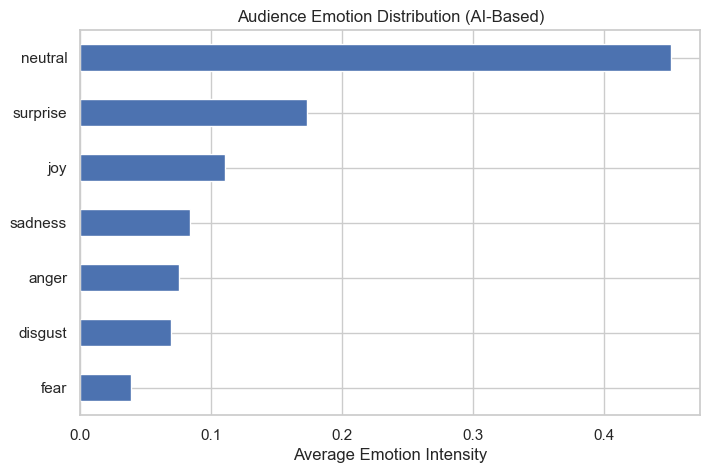

In [17]:
df_emotions.mean().sort_values().plot(
    kind="barh",
    figsize=(8,5)
)
plt.title("Audience Emotion Distribution (AI-Based)")
plt.xlabel("Average Emotion Intensity")
plt.show()


### 7.7 Video Comparative Analysis (Sentiment vs Performance)

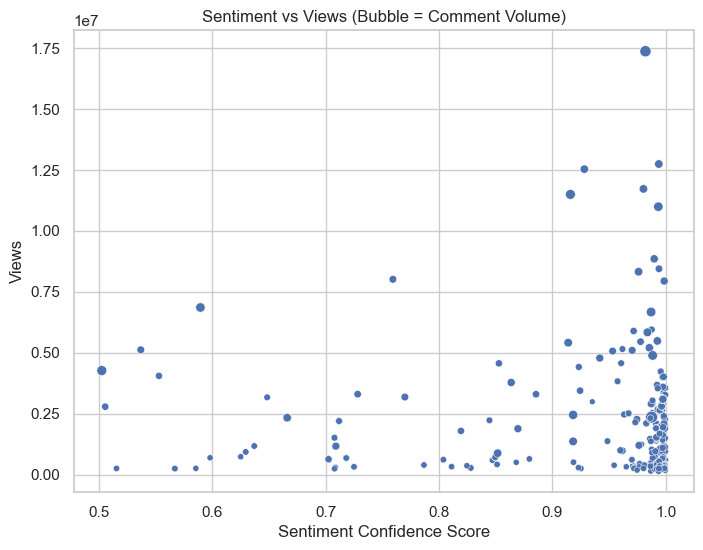

In [18]:
df_merge = df_transcripts.merge(
    pd.read_csv("../data/raw/videos/only_1_minute_videos.csv"),
    on="video_id"
)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_merge,
    x="sentiment_score",
    y="views",
    size="comments",
    legend=False
)
plt.title("Sentiment vs Views (Bubble = Comment Volume)")
plt.xlabel("Sentiment Confidence Score")
plt.ylabel("Views")
plt.show()


### 7.8 Save Outputs

In [19]:
df_transcripts.to_csv(
    "../data/processed/ai_transcript_analysis.csv",
    index=False
)

df_emotions.to_csv(
    "../data/processed/ai_comment_emotions.csv",
    index=False
)
